In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
cd ./drive/MyDrive/mask_detection/

/content/drive/MyDrive/mask_detection


In [ ]:
base = os.getcwd()
print(base)
print(os.listdir(base))
ds_path = os.path.join(base, "mask_ds")
print(ds_path)
print(os.listdir(ds_path))

/content/drive/MyDrive/mask_detection
['여러가지.ipynb', 'mask_ds']
/content/drive/MyDrive/mask_detection/mask_ds
['cor_mask', 'nomask', 'incor_mask']


## 데이터셋 설명:
- cor_mask, nomask, incor_mask
- 폴더별 1400장 씩 (총 4200 장)
- 1400 -> train 1000, valid 200, test 200


### 데이터 공유링크
https://drive.google.com/drive/folders/1QYrzMsNo5oLGO-sMddC3qDUYvVIxJfcf?usp=sharing

In [ ]:
# def imlist(path):
#     """
#     The function imlist returns all the names of the files in 
#     the directory path supplied as argument to the function.
#     """
#     return [os.path.join(path, f) for f in os.listdir(path)]

# imlist(ds_path)

In [ ]:
# imagePaths = list(paths.list_images(ds_path))
# imagePaths

## Face mask detecting training (preprocess)


In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(ds_path))
data = []
labels = []
# label_candidates = ['nomask','mask_inc', 'mask_cor']
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# 다 keras 기반 함수들 load_img -> img_to_arrary -> preprocess_input 
	image = load_img(imagePath, target_size=(224, 224)) # resizing
	image = img_to_array(image) # numpy array로 변환 
	image = preprocess_input(image) # compatible 한 전처리를 위해 위의 load_img랑 세트 ,mobilnetv2만을 위한 preprocess class
	# 픽셀값들이 샘플별로 -1 ~ 1로 스케일링

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# 메모리가 부족하면 HDF5를 활용하라는데... 더 큰 데이터셋 쓸거면 고려해볼만한듯...?

[INFO] loading images...


In [ ]:
print(data[1])
print(labels[1])

[[[-0.27058822 -0.23137254 -0.18431371]
  [-0.27843136 -0.23921567 -0.20784312]
  [-0.26274508 -0.2235294  -0.17647058]
  ...
  [ 0.8901961   1.          1.        ]
  [ 0.8901961   1.          1.        ]
  [ 0.8901961   1.          1.        ]]

 [[-0.12941176 -0.09019607 -0.06666666]
  [-0.14509803 -0.10588235 -0.08235294]
  [-0.12941176 -0.09019607 -0.05882353]
  ...
  [ 0.8901961   1.          1.        ]
  [ 0.8901961   1.          1.        ]
  [ 0.8901961   1.          1.        ]]

 [[-0.16862744 -0.12156862 -0.12156862]
  [-0.17647058 -0.12941176 -0.12941176]
  [-0.1607843  -0.11372548 -0.11372548]
  ...
  [ 0.90588236  1.          1.        ]
  [ 0.90588236  1.          1.        ]
  [ 0.90588236  1.          1.        ]]

 ...

 [[-0.56078434 -0.4980392  -0.3490196 ]
  [-0.56078434 -0.4980392  -0.3333333 ]
  [-0.5686275  -0.5058824  -0.35686272]
  ...
  [-0.5294118  -0.6313726  -0.69411767]
  [-0.654902   -0.69411767 -0.7411765 ]
  [-0.5137255  -0.5686275  -0.6156863 ]]

 [

In [ ]:
print(data[-1])
print(labels[-1])

[[[-0.94509804 -0.92941177 -0.9529412 ]
  [-0.92156863 -0.90588236 -0.92941177]
  [-0.90588236 -0.90588236 -0.92156863]
  ...
  [-0.06666666 -0.11372548 -0.23921567]
  [-0.01176471 -0.06666666 -0.20784312]
  [ 0.11372554  0.05098045 -0.09803921]]

 [[-0.94509804 -0.92941177 -0.9529412 ]
  [-0.92156863 -0.90588236 -0.92941177]
  [-0.92156863 -0.90588236 -0.92941177]
  ...
  [-0.35686272 -0.42745095 -0.4980392 ]
  [-0.11372548 -0.19215685 -0.26274508]
  [-0.01960784 -0.09803921 -0.17647058]]

 [[-0.9372549  -0.9372549  -0.9529412 ]
  [-0.92156863 -0.92156863 -0.9372549 ]
  [-0.90588236 -0.90588236 -0.92156863]
  ...
  [-0.19999999 -0.26274508 -0.36470586]
  [-0.08235294 -0.14509803 -0.24705881]
  [ 0.02745104 -0.04313725 -0.17647058]]

 ...

 [[-0.49019605 -0.49019605 -0.2862745 ]
  [-0.47450978 -0.47450978 -0.27058822]
  [-0.46666664 -0.49019605 -0.27843136]
  ...
  [-0.01960784 -0.35686272 -0.6313726 ]
  [-0.02745098 -0.34117645 -0.62352943]
  [-0.04313725 -0.35686272 -0.6392157 ]]

 [

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer() #sklearn LB vs onehot => int vs float...?
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# construct the training image generator for data augmentation, 다양한 변조이미지들로도 학습
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
?LabelBinarizer()

In [ ]:
labels.shape

(4200, 3, 2)

In [ ]:
labels[0] 

array([[0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
lb.y_type_

'multiclass'

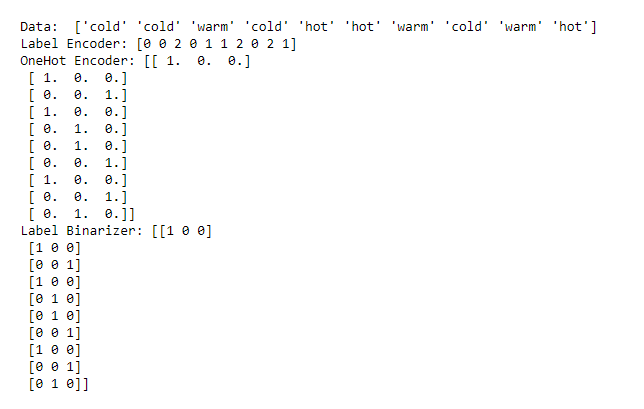

LabelEncoder – for labels(response variable) coding 1,2,3… [implies order]

OrdinalEncoder – for features coding 1,2,3 … [implies order]

Label Binarizer – for response variable, coding 0 & 1 [ creating multiple dummy columns]

OneHotEncoder - for feature variables, coding 0 & 1 [ creating multiple dummy columns]


=> OneHotEncoder produces a SciPy spares-matrix by default, while the LabelBinarizer produces a dense NumPy array by default.


https://stackoverflow.com/questions/50473381/scikit-learns-labelbinarizer-vs-onehotencoder

## Applying Face Detection w/ pretrained (Preprocess)

In [ ]:
# ?cv2.dnn.blobFromImage

## OpenCV's blobFromImage
- Blob => binary large object, 이미지,사운드, 비디오와 같은 멀티미디어 데이터를 다룰 때 사용

**1.   Mean Subtraction**

**2.   Scaling**

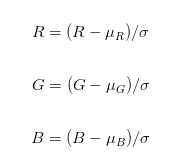

- 각 RGB 채널의 average pixel intensity 에 대해서 정규화
- 모든 딥러닝 아키텍쳐가 mean subtraction 방법을 요하진 않기에 다른 방법을 사용할 때는 관련 publication 혹은 documentation 확인이 필수적
- 어떤 경우에는 mean subtraction만 수행(시그마 = 1)

**3. (Optional) Channel Swapping**
- OpenCV 는 이미지가 BGR 채널 순서로 있다고 가정 => 평균값들은 RGB 순으로 입력/계산되기에 R과 B의 채널 을 바꿔줌...

**cnn.dnn.blobFromImage(image, scalefactor = 1.0, size, mean, swapRB = True)**

- image => dnn input 전에 전처리 원하는 이미지
- scalefactor => 시그마
- size => 우리는 300x300 or 224x224
- mean => RGB값에 대해서 해야하기에 (R,G,B) 의 3-tuple을 입력
- swapRB => T or F

=> 결과물로 binary large object를 출력

In [ ]:
image = cv2.imread(args["image"])
orig = image.copy()
(h, w) = image.shape[:2]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# image 별로 해당 RBB 튜플 순서대로 빼주고 1로 나누어주는 스케일링 진행 
# 모델에 맞는 이미지 사이즈로 입력
# swapRB 는 디폴트 T 이기에 생략
 # 여기서 (104.0,177.0,123.0)는 mean subtraction의 경험적 최적값...? 없이하면 trainset 에서 채널별로 평균 pixel intensity 사용??? 
 
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

In [ ]:
		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX] # face BB
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) # BGR2GRAY BGR 을 RGB color space 로 바꾸어줌 (byte  역순의 관계)
		face = cv2.resize(face, (224, 224)) # 224x224 로 resizing
		face = img_to_array(face)
		face = preprocess_input(face) #mobilnetv2만을 위한 preprocess class
		face = np.expand_dims(face, axis=0)
  
		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]